#Temas de conversacion sobre los campos de opiniones.


Hacer un análisis de los campos donde la gente deja su opinión sobre su estancia, y ver qué temas aparecen y cómo se representan. 

Tenemos disponibles :
Access, 
Description, 
Host about, 
House Rules,
Interaction,
NeighborhoodOverview
Space,
Summary.

In [1]:
#Instalacion librerias necesarias

!pip install gensim
!pip install pyLDAvis
!pip install spacy
!python -m spacy download es_core_news_sm
!python -m spacy download en_core_web_sm
!pip install stop_words

# Librerías
import gensim
from os.path import join
import csv
import spacy
from stop_words import get_stop_words
from string import punctuation
import re
import numpy as np
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import pandas as pd
import io
import es_core_news_sm

import warnings
warnings.filterwarnings('ignore')

     |████████████████████████████████| 1.6MB 2.8MB/s 
     |████████████████████████████████| 552kB 53.3MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=71841c7674f51de1da77850446b67ca72d93efa8149064fdab1d37899b6c7a72
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=84d50962acfc2da01e3002133398eed6818f5c67a7603e68fbb5e57d82bb28fc
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy
     |████████████████████████████████| 16.2MB 4.2MB/s 
  Created wheel for es-core-news-sm: filename=es_core_news_sm-2.2.5-cp36-none-any.whl size=16172936 sha256=c2a04e5ee37ddbf05bbce17256c5cfd95358f4965435ac594730c3a427d7a8c8
  Stored in directory: /tmp/pip-ephem-wheel-cache-kl1vk8ia/wheels/05/4f/66/9d0c806f86de08e8645d67996798c

Debido a que hay registros en español y en ingles, obtentemos la lista de stop-words en ambos idiomas

In [0]:
# Obtenemos una lista de 'stop words', palabras como artículos o adverbios que no son topics, en inglés
stop_words1 = get_stop_words('en') + list(punctuation) + [' ']
stop_words1_signos = [ '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']
nlp1 = spacy.load('en_core_web_sm', disable=['parser', 'tagger', 'ner', 'textcat'])

In [0]:
# Obtenemos una lista de 'stop words', palabras como artículos o adverbios que no son topics, en español
stop_words2 = get_stop_words('es') + list(punctuation) + [' ']
nlp2 = es_core_news_sm.load()

In [4]:
# Librerías y funciones necesarias
import numpy as np 
import pandas as pd
import openpyxl

import matplotlib.pyplot as plt 
%matplotlib inline

from sklearn.model_selection import train_test_split

# Conecta con google drive
from google.colab import drive
drive.mount('/content/drive')

# Carga del dataset de pisos de airbnb Madrid filtrado (13258 reg) sólo por la ciudad Madrid.
airbnbMadrid = pd.read_csv('/content/drive/My Drive/airbnblistingsMadridv1.csv', sep=';', decimal='.')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


###Búsqueda de Topics en la categoría "Description"

In [0]:
# Reduce dataset a la variable objetivo : 
airbnbMadridObj = airbnbMadrid['Description']

In [6]:
airbnbMadridObj

0        Habitación con cama de 150 ,  para una o dos p...
1        Bonito estudio en el barrio comercial y financ...
2        Bright and refurbished studio, located in one ...
3        Nice single room in the best area of Madrid. T...
4        Located in the heart of Barrio de Salamanca. S...
                               ...                        
13253    Shared room in a gay friendly apartment. The l...
13254    Shared room in a gay friendly apartment. The l...
13255    Coming to Madrid on your own? I will provide y...
13256    Lugares de interés: el aeropuerto, el centro d...
13257    MuchoMadrid offers accommodation in the heart ...
Name: Description, Length: 13258, dtype: object

In [7]:
# Se calcula el número de nulos
print(f'El dataframe tiene un total de {len(airbnbMadridObj)} filas.')
print(f'El dataframe tiene nulos : ', airbnbMadridObj.count())

El dataframe tiene un total de 13258 filas.
El dataframe tiene nulos :  13252


In [0]:
# Eliminacion de nulos y abreviatura del dataframe
df = airbnbMadridObj.fillna(' ')

In [0]:
# Se sustituyen los puntos por espacios. Si hay nulos,se sustituyen por espacios
for i in range(len(df)+1):
    try:
      df[i] = df[i].replace("."," ")
    except:
      df[i] = ' ' 

In [0]:
# Se eliminan las comas por espacios. Si hay nulos,se sustituyen por espacios
for i in range(len(df)+1):
    try:
      df[i] = df[i].replace(","," ")
    except:
      df[i] = ' '

In [0]:
# Filtramos los stop_words
documents = [] 

for q in df:                               # para cada registro del dataframe
    p = ""
    q = q.lower()                          # ponemos todas las letras en minúsculas

    for doc in (q.split(' ')):             # para cada palabra del registro
      if doc not in stop_words1 :          # filtra las stop words en ingles
         if doc not in stop_words2 :       # filtra las stop words en español
            p = p+doc+(' ')                # construimos un registro filtrado
    q=p

    r = ""                                
    for doc1 in q :                        # de nuevo, para cada palabra del registro ya filtrado
      if doc1 not in stop_words1_signos :  # filtramos los signos, no importa el idioma
         r = r+doc1                        # construimos un registro filtrado
    q=r

    q1 = [t.text for t in nlp1(q.rstrip(), disable=['parser', 'tagger', 'ner'])]
    q2 = [t.text for t in nlp2(q.rstrip(), disable=['parser', 'tagger', 'ner'])]
    documents.append(q1) # junta todo en un mismo corpus
    documents.append(q2) # junta todo en un mismo corpus

In [0]:
vocab = set([t for doc in documents for t in doc]) # conjunto de palabras(con lo que las palabras serán únicas)
w2id = {k:i for  i,k in enumerate(vocab)}          # crea un diccionario de las palabras de vocab 
id2w = {i:k for k, i in w2id.items()}              # lo convierte en tokens
print('{} unique tokens'.format(len(w2id)))        #  muestra el número de tokens únicos

32107 unique tokens


In [0]:
# Gensim es una biblioteca de código abierto para el modelado de temas no supervisados ​​y el procesamiento del 
# lenguaje natural, que utiliza el aprendizaje automático moderno de estadística.
from gensim.corpora import Dictionary

In [0]:
#Crea un diccionario con las palabras extraídas
gensim_dict = Dictionary(documents)
len(gensim_dict) # número de elementos del diccionario

32107

In [0]:
# corpus : colección de documentos
# doc2bow crea una bolsa de palabras (una lista con un núm id de la palabra y el número de veces que aparece)
corpus = [gensim_dict.doc2bow(doc) for doc in documents]

Implementación usando Gensim. Buscaremos el modelo con el número óptimo de topics y nos quedaremos con el que más coherencia nos dé.

In [0]:
#build a model
from gensim import corpora, models, similarities

# Buscaremos el número de topics que más coherencia nos de
from gensim.models import CoherenceModel
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaModel(corpus, id2word=dictionary, num_topics=num_topics, iterations=5, passes=20, alpha='auto')
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

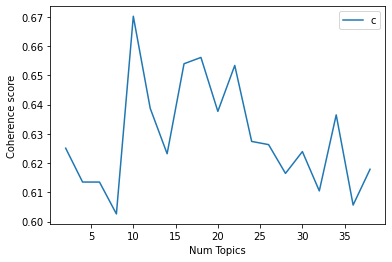

In [0]:
# Con un gráfico veremos más fácilmente
limit=40; start=2; step=2; # buscará topics de dos en dos, desde 2 hasta 40
model_list, coherence_values = compute_coherence_values(dictionary=gensim_dict, corpus=corpus, texts=documents, start=start, limit=limit, step=step)
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")           # eje x, número de topics
plt.ylabel("Coherence score")      # eje y, coherencia
plt.legend(("coherence_values"), loc='best')
plt.show()

In [0]:
# Buscamos el Máximo de coherencia y el num topicos adecuado
MaxCoherencia=max(coherence_values)
coherence_values.index(MaxCoherencia)
NumTopic=((coherence_values.index(MaxCoherencia)+1)*2)

print("Maxima coherencia : ", MaxCoherencia)
print("Num. Topics : ", NumTopic)


Maxima coherencia :  0.6702203789535502
Num. Topics :  10


In [0]:
# Modelo con mejor número de topics
# Entrena modelo LDA, pasándole el corpus y el diccionario calculado arriba.
# Se le pasa el NumTopic calculado arriba
lda_small = models.LdaModel(corpus, id2word=gensim_dict, num_topics=NumTopic, iterations=5, passes=20, alpha='auto')
print(lda_small.bound(corpus))
vis = pyLDAvis.gensim.prepare(lda_small, corpus, gensim_dict)
pyLDAvis.display(vis)

# Si vamos a los topics, y marcamos sobre ellos, muestra los términos más relevantes de ése topic.
# Para analizar los temas que genera el algoritmo veamos uno a uno :
# Num1 : Se concentra en describir cocina, cama, baño
# Num2 : Se centra en Madrid, centro, barrio
# Num3 : Se piensa en el Metro y la Casa


-15711691.40959698
